# Solving the Max Independent Set Problem

In this notebook, we will describe how to solve the **Max Independent Set** with LunaSolve. We will begin by defining, explaining and giving an example for the Max Independent Set problem. We will then continue by modeling a problem instance, optimize it and implement the solution using LunaSolve. Finally, we will also take a further look at the interpretation of the answer we are returned from Luna.


## Table of Contents

1. [Introduction](#1)
2. [Real World Example](#2)
3. [Solving the Max Independent Set problem with Luna](#3)



<a id="1"></a>
## 1. Introduction

## **Max Independent Set** 
The Max Independent Set problem is a classic puzzle in graph theory. The task is finding the biggest group of nodes in a graph where no two nodes are connected by an edge. Meaning a subset of the graph with no edges at all. In other words, it’s about picking a bunch of elements (nodes) that are totally independent of each other based on how they’re connected in the graph(edges).

Formally, let $G = (V, E)$ be an undirected graph. An *independent set* (or *stable set*) is a subset of vertices $S \subseteq V$ such that for every pair of distinct vertices $u, v \in S$, the edge $(u, v)$ does not belong to $E$. The Max Independent Set problem asks to find an independent set $S$ of maximum size.



<a id="2"></a>
## 2. Description

In the following example, we illustrate how to select the largest possible set of study rooms such that no two chosen rooms interfere with one another.

This concept could arise in a real-world setting—such as managing a library with multiple study rooms. Some rooms are located very close to each other, so if one person starts talking loudly in a nearby room, it can disrupt the others. The aim is to identify as many rooms as possible for studying without causing any disturbances between them.

Consider six study rooms labeled A, B, C, D, E, and F, with the following constraints:

- A and B cannot be used at the same time.
- A and C cannot be used at the same time.
- B and D cannot be used at the same time.
- C and D cannot be used at the same time.
- D and E cannot be used at the same time.
- E and F cannot be used at the same time.

These relationships can be conveniently represented by a graph, where each room corresponds to a node, and any pair of rooms that cannot be used together is connected by an edge.

<a id="3"></a>
## 3. Solving the Max Independent Set problem with Luna

To follow along with the next steps, three libraries are needed:
1. **luna-quantum** for encoding and solving our optimization problem,  
2. **matplotlib** for visualization, and  
3. **networkx** for creating and drawing the graph.  

The cell below installs these packages for you if they are not already installed.

In [1]:
# Install dependencies
%pip install --upgrade pip
%pip install luna-quantum --upgrade
%pip install matplotlib networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 3.1 Setup Luna Client
Now, let's walk through the implementation of the Max-Clique problem using LunaSolve. First, create an encryption key. You can generate a key [here](https://docs.aqarios.com/get-started#luna-encryption).

In [2]:
import os
os.environ["LUNA_ENCRYPTION_KEY"] = "gzaUL8hDECWXRcGrJiEa5wVWVgt4sgPbBDjKN8I92ps"

As the next step, instantiate a LunaSolve object and set your credentials. The API key is needed to identify you and grant access to the Luna platform. You can find it in your Aqarios account settings.

In [3]:
from luna_sdk import LunaSolve
ls = LunaSolve(api_key="60360df4e8b54305aababfa6ac99429e")

### 3.2 Create a Max Independent Set problem

To create a Max Independent Set instance, any graph with vertices and edges is sufficient. In this notebook, we’ll represent the relationships between the study rooms through a graph. The study rooms are represented as the nodes of the graph. Any time two rooms are close enough to disturb each other, we’ll draw an edge between them.

After defining the graph, we will visualize it for better comprehension.

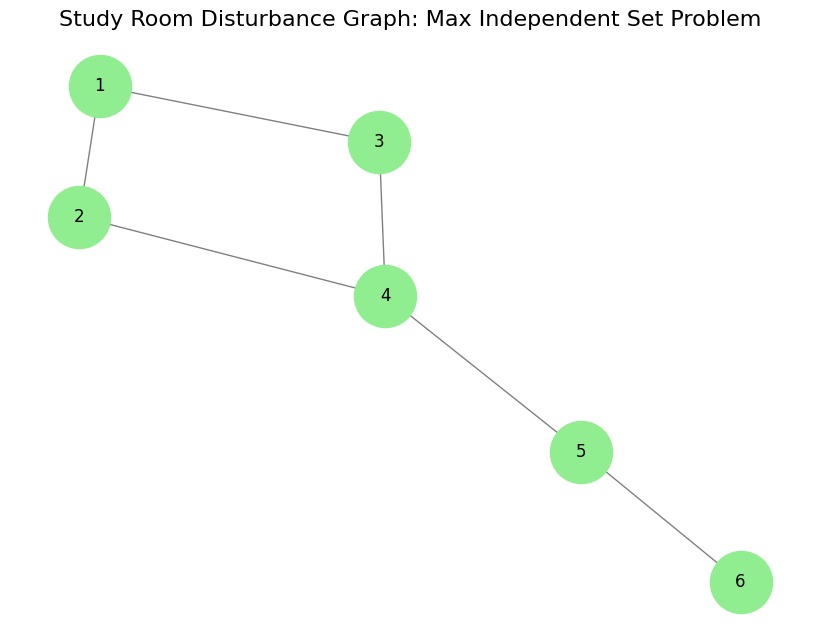

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
max_independent_set_graph = nx.Graph()

# Add nodes (study rooms)
rooms = [1, 2, 3, 4, 5, 6]
max_independent_set_graph.add_nodes_from(rooms)

# Add edges (disturbance relationships)
disturbances = [
    (1, 2),
    (1, 3),
    (2, 4),
    (3, 4),
    (4, 5),
    (5, 6)
]
max_independent_set_graph.add_edges_from(disturbances)

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(max_independent_set_graph)
nx.draw(
    max_independent_set_graph, pos, with_labels=True, node_size=2000, font_size=12, 
    node_color="lightgreen", font_color="black", edge_color="gray"
)
plt.title("Study Room Disturbance Graph: Max Independent Set Problem", fontsize=16)
plt.show()



Now we see the relationships between all rooms and their relationships w.r.t. their noise affections of each other. We will try to allocate the maximum number of rooms so that no other study room affects each other. Thereby being a set of nodes, in which no pairs are connected by an edge.

### 3.3 Creating a Max Independent Set Object
To find the largest independent set using LunaSolve, we define the Max Independent Set use case using Luna’s `MaxIndependentSet` class. This class converts the graph into a QUBO optimization problem, which Luna can then optimize.

In [5]:
# import the MaxCut object from the luna sdk
from luna_sdk.schemas import MaxIndependentSet

# create a MaxCut object
max_independent_set = MaxIndependentSet(graph=nx.to_dict_of_dicts(max_independent_set_graph))


### 3.4 Create a Luna Optimization

We can now upload the problem instance as an optimization to Luna and solve it afterward.

In [6]:
optimization = ls.optimization.create_from_use_case(name="Max Independent Set Sample Distribution", use_case=max_independent_set)

### 3.5 Create a Luna Solution

The next step involves creating a job, which is an outbound request to the hardware provider to solve the optimisation problem. By calling the `ls.solution.create()` method of LunaSolve we can create the outbound job. This method takes care of optimizing our problem. To solve the Max Independent Set problem, we pass the `optimization_id` from our optimisation object of our use case, specify the `solver_name` we choose, the `provider` of the computing hardware, `solver_parameters` (which may be specific to the solver), and a `qpu_token` if needed.

In this instance, we solve the Max Independent Set problem using simulated annealing (sa) and choose D-Wave (dwave) as the hardware provider.

In [7]:
job = ls.solution.create(
    optimization_id=optimization.id,
    solver_name="sa",
    provider="dwave",
    solver_parameters={}
)

### 3.6 Retrieve the Solution

In step 3.4, we uploaded the problem, and in 3.5, we made a solve request to Luna. Luna sends the optimisation problem to the provider specified and is returned a solution. Luna autonomously takes care of all background activities, during which the user can turn to other of their important matters. The background processes include the creation and translation of the optimisation problem for the according hardware provider, sending out the request and obtaining a result back, and translating the solution back to an interpretable format.

The `Solution` object created, has multiple attributes expressing different factors of the optimisation problem. These include meta data of the optimisation and the sampled results. The optimisation meta data includes information attached to the use case problem, such as `id`, `name`, `solver`and `provider` names, `runtime` and `qpu` type. Lastly, the `status` variable indicates if the job has been successfully executed and returned to Luna. If the status variable says DONE, the optimisation has finished. In the case REQUESTED is displayed for the status, your optimisation is still being processed. Wait a little bit and re-execute the cell, to retrieve the updated solution.

In [12]:
solution = ls.solution.get(solution_id=job.id)
print(solution)

id: 67b5f0a4acb6eea462be3a73
name: Max Independant Set Sample Distribution
status: DONE
solver: SA
provider: dwave
runtime:
    total: 0.006380321923643351
    qpu: None
optimization_name: QUBO_MATRIX
created_date: 2025-02-19 14:54:28 (+07)
results:
1 results found. Displaying first 5 results.
Result 1:
    {'sample': {'x0': 1.0, 'x1': 1.0, 'x2': 0.0, 'x3': 0.0, 'x4': 0.0, 'x5': 1.0}, 'obj_value': -3.0, 'feasible': True, 'constraints': {}}



Because we converted the use case into the QUBO format, the solution we are returned from our provider is also in this format, which typically is in a vectorised form. However, the encoding from our original optimisation problem might be different. Slack variables, linearisations and transformations between optimisation formats can alter the variable description of optimisation methods. As aforementioned, Luna performs a post-processing step which transforms the solution from the QUBO domain back to a more intuitive domain. 

The `ls.solution.get_use_case_representation(solution_id=job.id)` method transforms the solution of our optimisation to a readable format. The `sense`attribute informs us if we are trying to maximize or minimize our objective function. The `result` is typically given as an iterable containing the `representation` which contains the solution, and the `òbj_value`. The objective value is difficult to interpret as it encompasses both optimization values and constraint penalties, however smaller values express better solutions. The `description` explains the encoding of the `representation` of the result. 

The formal definition of the Max Independent Set problem is simple. The variables $x_i$ encode decision variables which are values given to the nodes of the graph. If the value of $x_i$ is equal to one, it means that the node (study room) is part of the maximally independent set.

Accordingly, in the case of the Max Independent Set problem, the representation is a list which contains the indices of all nodes that are included in the maximally independent set. In other words, the representation is a list of all indices $i$, for which their decision variable $x_i$ is equal to one. 


In [13]:
use_case_repr = ls.solution.get_use_case_representation(job.id)
print(use_case_repr)


sense: min
results: [{'representation': [0, 1, 5], 'obj_value': -3.0}]
description: Solution is a list containing the indices of the nodes that are part of the maximum independent set.



Finally, if we wish to see the best solution from all evaluated samples we can call the `ls.solution.get_best_use_case_result(use_case_representation=use_case_repr)` method.

In [14]:
best_solution = ls.solution.get_best_use_case_result(use_case_repr)
print(best_solution)

representation=[0, 1, 5] obj_value=-3.0


In order to better grasp the solution, we can visualise the set and its dependencies using the graph we created, and colour all nodes which have a value of 0 red and all others that are 1, green.

['green', 'green', 'red', 'red', 'red', 'green']


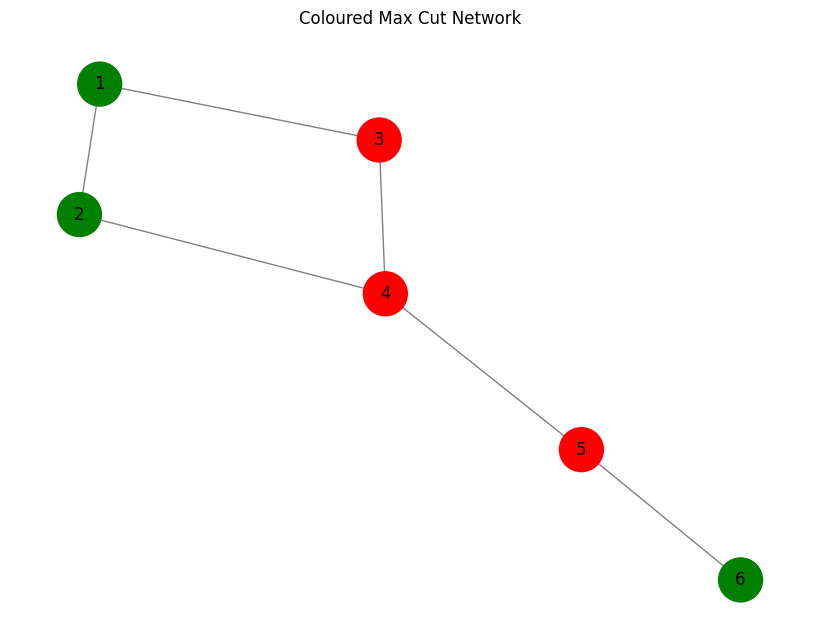

In [20]:
# colour the nodes based on the best result

colours = ["red" for _ in max_independent_set_graph.nodes]

for i in best_solution.representation:
    colours[i] = "green"

print(colours)
# Draw the graph with new coloring
plt.figure(figsize=(8, 6))
nx.draw(max_independent_set_graph, pos, with_labels=True, node_color=colours, edge_color="gray", node_size=1000, font_size=12)
plt.title("Coloured Max Cut Network")
plt.show()

Interpret the result: